# Use case: multi-band photometry, masked arrays

**Note:** This notebook presents an example of advanced use of the `isophote` package. If you didn't read the other notebboks and are not familiar with this kind of analysis, we recommend you do so before tackling this script. 

In this example, we want to build a color profile of a galaxy using two images taken with different filters. One has a higher S/N ratio than the other. We run the `ellipse` fitting on the high-S/N image, and then, using the isophotes so derived, get data for matching isophotes on the low-S/N image, at the corresponding positions, but without fitting. In that way, we can directly compare the photometry among the two isophote lists.

In this example we use public domain images of NGC1068 from the Hubble Space Telescope archive (https://www.spacetelescope.org/projects/fits_liberator/ngc1068data/). 

The high-S/N image is a wide-band near-IR image, the other is a narrow-band H$\alpha$ + [NII]. Due to the detector shapes, the image frames do contain extensive regions with no meaningful information in them. These regions have to be masked out. The `isophote` package can handle `numpy` masked arrays, thus we build masked image frames before submitting then for analysis.

Note that the use of masked arrays slows down the computations quite significantly. This entire script takes ~40 min. to finish on a Mac Pro 3.7 GHz Xeon E5.

### Procedure

1 - fit isophotes on the higher S/N wide band image. This creates a list of Isophote instances.

2 - loop over the list and extract the geometry of these isophotes, one by one. 

3 - for each value of the `sma` and other geometrical parameters in that isophote, extract a matching sample from the low-S/N image, without fitting.

4 - store this sample as a new Isophote instance in a second list.

This procedure will avoid fitting problems on the low-S/N image, allowing it to be sampled at regions where the fitting algorithm wouldn't be able to perform meaningful fits.

The end product of this procedure is a set of two `IsophoteList` instances, one for each image. Corresponding `Isophote` instances in each list will match geometrically, thus direct comparison of their photometry can be made. Specifically, we can directly plot the radial dependency of the ratio of intensities in the narrow and wide band images. 

### 1 - Read images and mask out unwanted regions

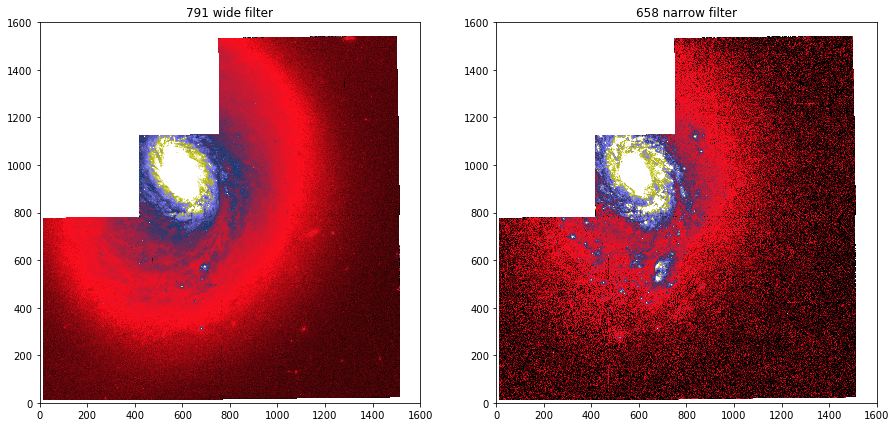

In [1]:
from astropy.io import fits
from astropy.utils.data import download_file

# This was copied from the astropy-tutorials/Contributing.md file,
# but doesn't work (generates a 'unknown url' error).
# tutorialpath = ''
# 791wmos = download_file(tutorialpath + '791wmos.fits', cache=True)
# image = fits.open(791wmos)
image = fits.open('791wmos.fits')
pixel_data_791 = image[0].data
image = fits.open('658nmos.fits')
pixel_data_658 = image[0].data

# build numpy masked arrays. In these images, pixels with no 
# information in then are signaled by the value zero. We use 
# that to build the masks.
import numpy as np
import numpy.ma as ma
pixel_data_658 = ma.masked_equal(pixel_data_658, np.zeros(shape=pixel_data_658.shape))
pixel_data_791 = ma.masked_equal(pixel_data_791, np.zeros(shape=pixel_data_791.shape))

# visually inspect the images.
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
limits = [0,1600]
ax1.imshow(pixel_data_791, cmap=cm.gist_stern, vmin=0, vmax=400)
ax1.set_xlim(limits)
ax1.set_ylim(limits)
ax1.set_title("791 wide filter")
ax2.imshow(pixel_data_658, cmap=cm.gist_stern, vmin=0, vmax=50)
ax2.set_xlim(limits)
ax2.set_ylim(limits)
ax2.set_title("658 narrow filter")

### 2 - Start a basic fitting procedure on the high-S/N image

This usually requires some trial and error in order to evaluate the abilities of the algorithms regarding the particular image being analysed. In this case, we want to see how far out on the high-S/N image the ellipse fitting algorithm will go before significance is lost.

In [2]:
from photutils.isophote.geometry import Geometry
from photutils.isophote.ellipse import Ellipse

# we start with first guesses for the geometry parameters
# gleaned from visual inspection of the image itself.
x0 = 590.    # center position
y0 = 970.    # center position
sma = 100.   # starting semi-major axis length in pixels
eps = 0.3    # ellipticity
pa = 120. / 180. * np.pi # position angle

g = Geometry(x0, y0, sma, eps, pa)
ellipse = Ellipse(pixel_data_791, geometry=g)

Centering on object....   Done. Found x0 = 586.0, y0 = 965.0


For the actual fit we use default parameter values, except that we use 'median' integration mode, sigma-clipping of the integrated values, and a more lax criterion for the flagged data points. This choice of parameters should probably decrease the influence of bright starts and HII regions on the basically elliptical underlying light distrubution. And also allow ellipses be fitted even though we have large regions masked out of the image.

In [3]:
w_list = ellipse.fit_image(integrmode='median', sclip=3.0, nclip=3, fflag=0.3,)

#
# Semi-      Isophote         Ellipticity    Position     Grad.   Data  Flag Iter. Stop
# major        mean                           Angle        rel.                    code
# axis       intensity                                    error
#(pixel)                                     (degree)
#
 100.00      504.21 ( 6.74)  0.379 (0.002) 110.10 ( 0.2)  0.135   106     1   20     0
 110.00      472.08 ( 6.57)  0.414 (0.002) 110.10 ( 0.2)  0.118   105     2   10     0
 121.00      377.13 ( 5.12)  0.330 (0.003) 129.96 ( 0.3)  0.142   120     3   10     0
 133.10      352.42 ( 3.29)  0.374 (0.002) 129.68 ( 0.2)  0.122   116     5   10     0
 146.41      289.09 ( 3.70)  0.317 (0.002) 125.41 ( 0.2)  0.086   124     3   10     0
 161.05      237.14 ( 3.20)  0.317 (0.001) 127.68 ( 0.1)  0.073   127     0   10     0
 177.16      195.54 ( 3.07)  0.342 (0.001) 128.92 ( 0.1)  0.063   119     8   10     0
 194.87      140.53 ( 2.08)  0.349 (0.002) 126.80 ( 0.2)  0.123   109    18   10     0
 214.3

/Users/busko/Projects/miniconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/busko/Projects/miniconda3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/busko/Projects/miniconda3/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/busko/Projects/miniconda3/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/busko/Projects/miniconda3/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 259.37       88.68 ( 1.77)  0.316 (0.022) 115.91 ( 1.2)  0.237    77    50    3     5
 285.31       78.01 ( 1.81)  0.316 (0.102) 115.91 ( 6.4)  0.766    71    56    5     5
  90.91      609.13 ( 8.17)  0.418 (0.003) 111.33 ( 0.2)  0.141    96     0   10     0
  82.64      621.78 ( 6.53)  0.366 (0.002) 114.87 ( 0.2)  0.131    95     3   10     0
  75.13      725.13 (10.26)  0.366 (0.003) 116.07 ( 0.2)  0.114    92     0   10     0
  68.30      795.59 (10.47)  0.329 (0.002) 119.30 ( 0.3)  0.107    91     0   10     0
  62.09      867.77 ( 9.99)  0.285 (0.002) 119.80 ( 0.3)  0.115    89     0   10     0
  56.45      922.81 ( 9.32)  0.234 (0.003) 119.80 ( 0.4)  0.119    87     0   10     0
  51.32      986.53 ( 9.14)  0.184 (0.003) 125.22 ( 0.4)  0.109    82     2   10     0
  46.65     1100.83 (11.10)  0.218 (0.004) 130.13 ( 0.6)  0.143    73     0   10     0
  42.41     1153.24 (11.58)  0.147 (0.005) 130.13 ( 1.0)  0.177    73     0   10     0
  38.55     1327.91 (12.79)  0.181 (0.004) 

Note that the fit won't proceed beyond `sma~240`. The condition is signaled by the `numpy` warnings, and by the stop code $5$ at `sma=259` and beyond. Something in the image there prevents the algorithm to ever find a satisfactory solution. 

Note also that the central peak measurement (last row above) looks wrong. It's probably a side effect of the previous fits failures at `sma ~< 1`.

Lets plot some isophotes on top of the image:

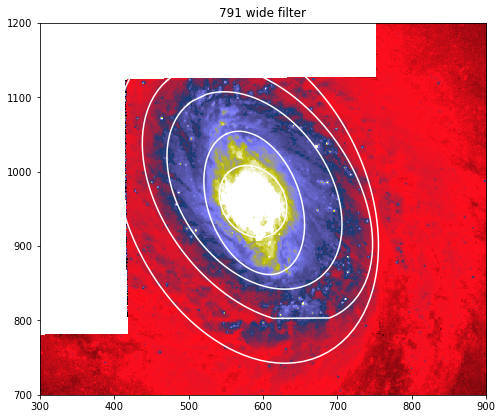

In [4]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(pixel_data_791, cmap=cm.gist_stern, vmin=0, vmax=1200)
ax.set_xlim([300,900])
ax.set_ylim([700,1200])
ax.set_title("791 wide filter")

# go to the outermost successfully fitted ellipse at sma=235
for sma in [50.,100.,150.,200.,235.]:
    iso = w_list.get_closest(sma)
    x, y, = iso.sampled_coordinates()
    plt.plot(x, y, color='w')

Lets plot some samples:

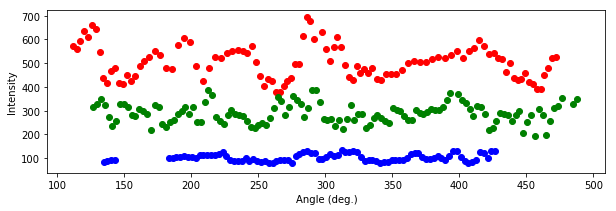

In [5]:
plt.figure(figsize=(10, 3))
plt.ylabel("Intensity")
plt.xlabel("Angle (deg.)")
for sma,color in zip([100.,150.,230.],['r','g','b']):
    iso = w_list.get_closest(sma)
    plt.scatter((iso.sample.values[0]+iso.sample.geometry.pa)/np.pi*180., iso.sample.values[2], color=color)

These plots suggest that the basic elliptical component of the light distribution was accounted for by the fit. No significant first or second order harmonics seem to be present. The remaining oscillations in these residuals are a sign of non-elliptical components still remaining in the image, as expected from such galaxy.

### 3 - Fit outer regions of the galaxy

From the image display we can see that there is still plenty of signal outside `sma=235` to perform reasonable fits. In a situation like this, we can try to resume the fit past the problematic region. We run the fit from a new instance of class `Ellipse`, initialized with geometry parameters gleaned visualy form the outer regions of the galaxy. We also use a larger `step` parameter so as to increase the distance between successive ellipses. This has the benefit of increasing the areas of integration used to extract each data point along a elliptical path, thus improving the S/N ratio. 

In [6]:
x0 = 600. 
y0 = 970.
sma = 300. # start from here, and use this as the minimum sma to fit as well.
eps = 0.2
pa = 70. / 180. * np.pi
g = Geometry(x0, y0, sma, eps, pa)
ellipse = Ellipse(pixel_data_791, geometry=g)
w_list_outer = ellipse.fit_image(integrmode='median',step=0.3,minsma=300.,maxsma=1000.,fflag=0.3,sclip=3.0,nclip=3)

Centering on object....   Done. Found x0 = 605.0, y0 = 965.0
#
# Semi-      Isophote         Ellipticity    Position     Grad.   Data  Flag Iter. Stop
# major        mean                           Angle        rel.                    code
# axis       intensity                                    error
#(pixel)                                     (degree)
#
 300.00       58.37 ( 0.77)  0.094 (0.032)  46.42 ( 2.9)  0.174    79    48   20     0
 390.00       44.24 ( 0.62)  0.094 (0.004)  94.86 ( 3.6)  0.124    81    46   10     0
 507.00       35.96 ( 0.38)  0.201 (0.004)  86.23 ( 1.5)  0.078    78    49   10     0
 659.10       18.85 ( 0.07)  0.201 (0.001)  66.12 ( 0.2)  0.035    80    47   10     0
 856.83       10.22 ( 0.04)  0.130 (0.010)  78.80 ( 4.6)  0.045    62    65   10     0
 230.77      110.79 ( 1.94)  0.298 (0.005) 102.86 ( 0.3)  0.155   100    27   10     0


The fit went well down to the edge of the usable data. Comparing the isophote plots below with the plots for the inner region, we can see that there seems to be a sudden change in geometry at around `sma~250`. Ellipses get rounder and the position angle twists by a significant amount at that region, which may explain why the fit there was problematic on the first try.

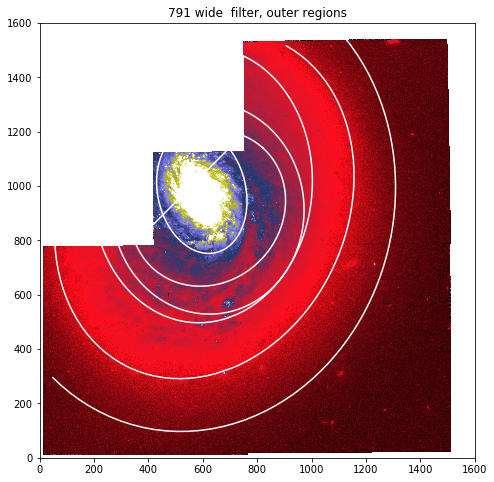

In [7]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(pixel_data_791, cmap=cm.gist_stern, vmin=0, vmax=400)
ax.set_xlim(limits)
ax.set_ylim(limits)
ax.set_title("791 wide  filter, outer regions")
for sma in [230.,300.,400.,500.,700.,900.]:
    iso = w_list_outer.get_closest(sma)
    x, y, = iso.sampled_coordinates()
    plt.plot(x, y, color='white')

The plot below also confirms that the fit went well. There is no suggestion that strong first and second harmonics are present after the fit.

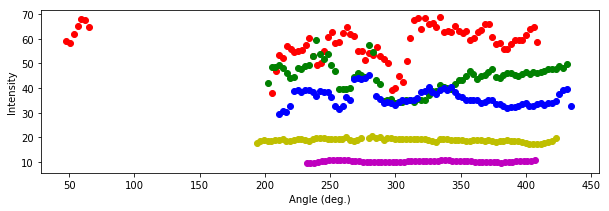

In [8]:
plt.figure(figsize=(10, 3))
plt.ylabel("Intensity")
plt.xlabel("Angle (deg.)")
for sma,color in zip([300.,400.,500.,700.,900.],['r','g','b','y','m']):
    iso = w_list_outer.get_closest(sma)
    plt.scatter((iso.sample.values[0]+iso.sample.geometry.pa)/np.pi*180., iso.sample.values[2], color=color)

### 4 - Combine results from inner and outer regions

Now we merge results from the two fits into a single instance of `IsophoteList`. At the same time, we discard the bad fits. Note that the `IsophoteList` instance can be handled in just the same way as any regular python `list`. It supports slicing, concatenation, insert/append, sorting.

In [9]:
w_list_combined = w_list[7:-2] + w_list_outer

### 5 - Add central peak measurement

In the combination above, we discarded the suspiciously-looking central peak measurement. Lets try to get a better measurement. 

(950, 970)

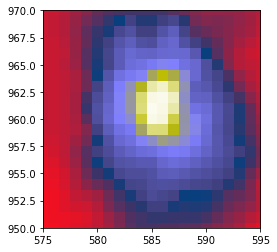

In [10]:
# display central region so we can have a better estimate of the peak's position.
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(pixel_data_791, cmap=cm.gist_stern, vmin=0, vmax=26000)
ax.set_xlim([575,595])
ax.set_ylim([950,970])

Now, we use the subclasses in the `isophote` package that are dedicated to handling the central peak.

In [11]:
from photutils.isophote.sample import CentralSample
from photutils.isophote.fitter import CentralFitter
from photutils.isophote.centerer import Centerer

# central peak position gleaned from the above display.
g = Geometry(586., 962., 0.0, 0., 0.)

# we use the Centerer class to fine tune and confirm our
# choice of central pixel. 
centerer = Centerer(pixel_data_791, g)
centerer.center()

# then we build a CentralSample instance and call the 
# CentralFitter on it.
sample = CentralSample(pixel_data_791, 0., geometry=g)
fitter = CentralFitter(sample)
center = fitter.fit()
print(center)

Centering on object....   Done. Found x0 = 586.0, y0 = 962.0
   0.00    25485.39


Finally, we add the central "isophote" to the list, and sort it so it looks neat. Note that the `fitter.fit()` method call above always returns an instance of `Isophote` or a subclass. The `center` object in the code above can thus be directly added to the `w_list_combined` `IsophoteList` instance.

In [12]:
w_list_combined.append(center)
w_list_combined.sort()

This is the final product for the high-S/N image: 

In [13]:
for iso in w_list_combined:
    print(iso)

   0.00    25485.39
   0.94    25308.84 (15.23)  0.494 (0.010)  61.39 ( 0.8)  0.338    13     0   18     0
   1.03    25258.48 (19.39)  0.471 (0.012)  74.50 ( 1.1)  0.415    13     0   10     0
   1.13    25211.85 (23.21)  0.489 (0.012)  80.25 ( 1.0)  0.386    13     0   10     0
   1.25    25144.06 (25.45)  0.508 (0.009)  82.06 ( 0.7)  0.277    13     0   10     0
   1.37    24987.44 (29.21)  0.495 (0.009)  81.15 ( 0.7)  0.282    13     0   10     0
   1.51    24771.20 (40.07)  0.469 (0.010)  80.61 ( 0.9)  0.286    13     0   10     0
   1.66    24490.61 (55.70)  0.436 (0.010)  79.15 ( 0.9)  0.265    13     0   10     0
   1.83    23950.50 (73.28)  0.371 (0.011)  76.92 ( 1.1)  0.295    13     0   10     0
   2.01    23253.81 (100.83)  0.322 (0.009)  77.98 ( 1.0)  0.176    13     0   10     0
   2.21    22350.30 (92.64)  0.304 (0.006)  78.67 ( 0.7)  0.150    13     0   10     0
   2.43    21007.01 (125.90)  0.276 (0.007)  80.38 ( 0.9)  0.151    14     0   10     0
   2.67    19573.01 (

### 6 - Plot some diagnostics

As we did in previous tutorials, we plot profiles of some of the isophote parameters to make sure they are OK.

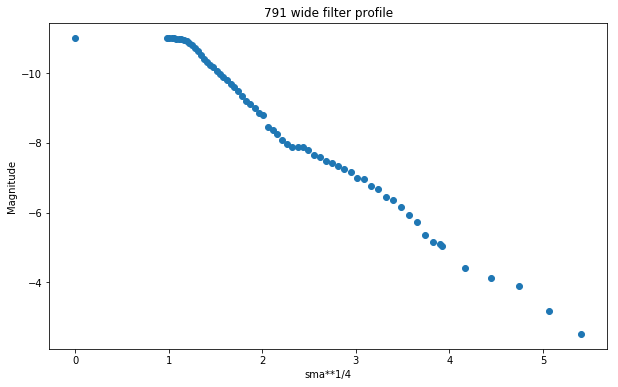

In [14]:
plt.figure(figsize=(10, 6))
plt.scatter(w_list_combined.sma**0.25, -2.5*np.log10(w_list_combined.intens))
plt.xlabel('sma**1/4')
plt.ylabel('Magnitude')
plt.gca().invert_yaxis()
plt.title("791 wide filter profile")

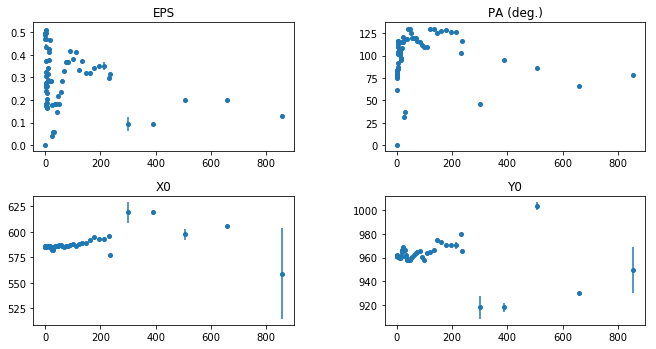

In [15]:
plt.figure(figsize=(10, 5))
plt.figure(1)

plt.subplot(221)
plt.errorbar(w_list_combined.sma, w_list_combined.eps, yerr=w_list_combined.ellip_err, fmt='o', markersize=4)
plt.title('EPS')

plt.subplot(222)
plt.errorbar(w_list_combined.sma, w_list_combined.pa/np.pi*180., yerr=w_list_combined.pa_err/np.pi* 80., fmt='o', markersize=4)
plt.title('PA (deg.)')

plt.subplot(223)
plt.errorbar(w_list_combined.sma, w_list_combined.x0, yerr=w_list_combined.x0_err, fmt='o', markersize=4)
plt.title('X0')

plt.subplot(224)
plt.errorbar(w_list_combined.sma, w_list_combined.y0, yerr=w_list_combined.y0_err, fmt='o', markersize=4)
plt.title('Y0')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35, wspace=0.35)

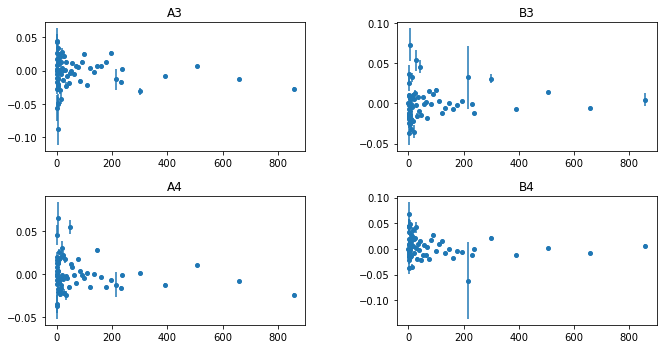

In [16]:
plt.figure(figsize=(10, 5))
plt.figure(1)

plt.subplot(221)
plt.errorbar(w_list_combined.sma, w_list_combined.a3, yerr=w_list_combined.a3_err, fmt='o', markersize=4)
plt.title('A3')

plt.subplot(222)
plt.errorbar(w_list_combined.sma, w_list_combined.b3, yerr=w_list_combined.b3_err, fmt='o', markersize=4)
plt.title('B3')

plt.subplot(223)
plt.errorbar(w_list_combined.sma, w_list_combined.a4, yerr=w_list_combined.a4_err, fmt='o', markersize=4)
plt.title('A4')

plt.subplot(224)
plt.errorbar(w_list_combined.sma, w_list_combined.b4, fmt='o', yerr=w_list_combined.b4_err, markersize=4)
plt.title('B4')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35, wspace=0.35)

### 7 - Use the isophote list just created to drive the sampling on the low-S/N image

In [17]:
from photutils.isophote.sample import Sample
from photutils.isophote.isophote import Isophote, IsophoteList

# Temporary list to store instances of Isophote
n_list_ = []

# Loop over the IsophoteList instance with data from the high-S/N image. 
#
# Note that we skip the first isophote. It's an instance of CentralPixel, 
# which requires special sampling by the CentralSample subclass. The 
# loop below is coded to handle regular Sample instances only.
for iso in w_list_combined[1:]:

    # Get the Geometry of each fitted isophote as determined by 
    # fitting on the high-S/N inage.
    g = iso.sample.geometry

    # Sample the low-S/Nimage at the same geometry. Use same integration 
    # mode so as to ensure the same regions in each image are sampled. 
    # Use same clipping parameters as used in the high-S/N image.
    sample = Sample(pixel_data_658, g.sma, geometry=g, integrmode='median', \
                    sclip=3.0,nclip=3)
    sample.update()

    # Create an Isophote instance with the sample, and store it in 
    # temporary list. Here we are using '0' as the number of iterations,
    # 'True' for the validity status, and '0' for the stop code. These
    # are in fact arbitrary in this context; you could use anything you
    # like.
    iso_ = Isophote(sample, 0, True, 0)
    n_list_.append(iso_)

# Build the IsophoteList instance with the result.
n_list = IsophoteList(n_list_)

In [18]:
print(len(n_list))

65


We still need to add the central peak's measuremet to the list just built.

### 8 - Get central peak measurement on low-S/N image

Lets proceed as in **5** above.

(955, 975)

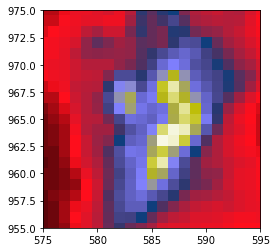

In [19]:
# display central region so we can have a better estimate of the peak's position.
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(pixel_data_658, cmap=cm.gist_stern, vmin=0, vmax=23000)
ax.set_xlim([575,595])
ax.set_ylim([955,975])

The peak is ill-defined here. Lets try first with the Centerer class.

In [20]:
g = Geometry(587., 962., 0.0, 0., 0.)
centerer = Centerer(pixel_data_658, g)
centerer.center()

Centering on object....   Done. Found x0 = 587.0, y0 = 966.0


Apparently the Centerer algorithm is not capable of finding the correct peak here. The next best thing would be to see what the `ellipse` fitting algorithm found in the region that immediately surrounds the peak. **Note:** pixel coordinates in the `isophote` package are zero-indexed.

In [21]:
for iso in n_list[0:5]:
    print(iso.sma, iso.x0, iso.y0)

0.9370406407450692 585.502744604 961.351935643
1.0307447048195761 585.499025083 961.26460524
1.1338191753015339 585.493562161 961.201162765
1.2472010928316872 585.507549338 961.175198894
1.371921202114856 585.542334525 961.2237672


The best position estimate seems to be a combination of what the fit algorithm sees, with what we see in the actual image. Note that this estimate matches the center position found in the high-S/N image within 0.5 pixel.

In [22]:
g = Geometry(586., 963., 0.0, 0., 0.)
sample = CentralSample(pixel_data_658, 0., geometry=g)
fitter = CentralFitter(sample)
center = fitter.fit()
n_list.append(center)
n_list.sort()

This is how the result for the low-S/N image looks like.

In [23]:
for iso in n_list:
    print(iso)

   0.00    22337.90
   0.94    18098.10 (373.43)  0.494 (0.039)  61.39 ( 3.2)  3.455    13     0    0     0
   1.03    17914.62 (396.70)  0.471 (0.037)  74.50 ( 3.2)  2.514    13     0    0     0
   1.13    17712.81 (401.13)  0.489 (0.032)  80.25 ( 2.7)  2.116    13     0    0     0
   1.25    17508.46 (399.93)  0.508 (0.030)  82.06 ( 2.4)  1.746    13     0    0     0
   1.37    17187.61 (401.64)  0.495 (0.036)  81.15 ( 3.0)  1.602    13     0    0     0
   1.51    16711.35 (452.33)  0.469 (0.044)  80.61 ( 3.7)  1.782    13     0    0     0
   1.66    16250.87 (597.17)  0.436 (0.050)  79.15 ( 4.5)  2.100    13     0    0     0
   1.83    15469.22 (780.91)  0.371 (0.042)  76.92 ( 4.2)  2.094    13     0    0     0
   2.01    14556.70 (916.80)  0.322 (0.029)  77.98 ( 3.3)  1.744    13     0    0     0
   2.21    13556.73 (985.15)  0.304 (0.075)  78.67 ( 8.7)  4.350    13     0    0     0
   2.43    12980.11 (1070.44)  0.276 (0.056)  80.38 ( 7.5)  3.398    14     0    0     0
   2.67    

In the printout above, we can spot the very effect we are trying to account for with this elaborate strategy: values of the Gradient Relative Error are tipically larger (sometimes not even measurable) than in the corresponding isophotes of the high-S/N image.

### 9 - Plot diagnostics

The radial profile for the low-S/N image looks like this.

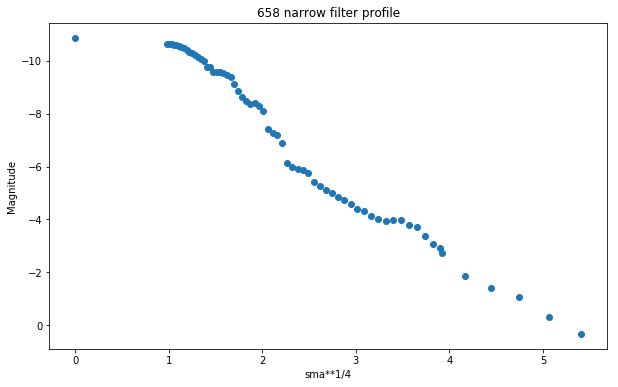

In [24]:
plt.figure(figsize=(10, 6))
plt.scatter(n_list.sma**0.25, -2.5*np.log10(n_list.intens))
plt.xlabel('sma**1/4')
plt.ylabel('Magnitude')
plt.gca().invert_yaxis()
plt.title("658 narrow filter profile")

### 10 - Final result

The main result we are looking for in this script is the radial profile of the ratio narrow/wide. It looks like this.

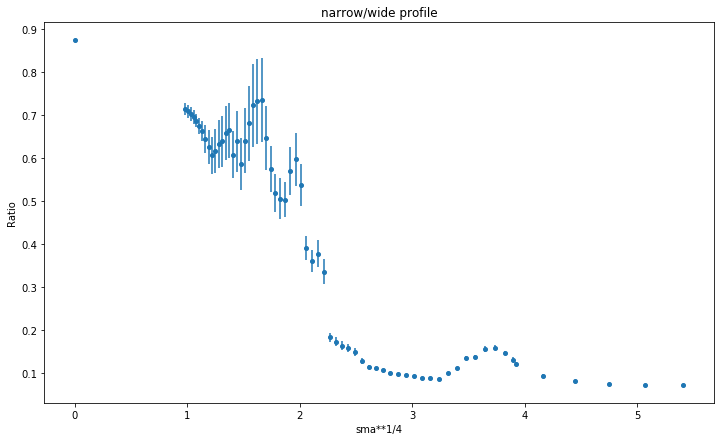

In [25]:
plt.figure(figsize=(12, 7))
# this is an approximation (assumes errors are uncorrelated)
errors = n_list.intens/w_list_combined.intens * np.sqrt(
    (n_list.int_err / n_list.intens)**2 + 
    (w_list_combined.int_err / w_list_combined.intens)**2)
plt.errorbar(n_list.sma**0.25, (n_list.intens/w_list_combined.intens), yerr=errors, fmt='o', markersize=4)
plt.xlabel('sma**1/4')
plt.ylabel('Ratio')
plt.title("narrow/wide profile")

### Disclaimer

The whole point of this script is to showcase how we can use the `isophote` package algorithms to measure complex sets of images. In no way we intended to do any meaningful science here. The particular choice of images for this exercise was based mostly on their wide availability in the public domain.

As an example on how the "science" here might be easily improved, we note that the very use of sigma-clipping when extracting photometry from the images may counteract the fact that perhaps a good fraction of the total light, in particular in the narrow-band filter, may come from the very [HII] regions we are trying to remove with sigma-clipping in the first place. 

The next level of improvement would probably have to use sigma-clipping and other masking techniques at a first fitting step, to establish once  and for all the geometry of the ellipses. Then, using that geometry, extract the photometry without sigma-clip, using on each one of the images a double-pass method similar to the procedure we describe here for the two images taken together. 

The procedure outlined in this script was obviously designed for images that precisely overlap, both in position and orientation, as well as plate scale and higher-order geometrical distortions.